# Numerical approximation of FBSDEs

Consider following FBSDE:

The forward part:
$$
\left\{\begin{array} {l} {{d X_{t}=\mu( t, X_{t} ) d t+\sigma( t, X_{t} ) d W_{t}, \quad t \in[ 0, T ]}} \\ {{X_{0}=x,}} \\ \end{array} \right.  
$$
and backward part:
$$
\left\{\begin{array} {l} {{{-d Y_{t}=f \left( t, X_{t}, Y_{t}, Z_{t} \right) d t-Z_{t} d W_{t}, \quad t \in[ 0, T ]}}} \\ {{{Y_{T}=\Phi( X_{T} ),}}} \\ \end{array} \right. 
$$

which have under certain conditions of the functions has an unique solution $(X,Y,Z)$.

## Euler sheme forward part

We time discretize uniformly with time step $\Delta_{i}^{N}$ 
 the forward SDE using an Euler scheme:

$$
\left\{\begin{array} {l} {{X_{0}^{N}=X_{0}}} \\ {{X_{t_{i}}^{N}=X_{t_{i-1}}^{N}+\mu \left( t_{i-1}, X_{t_{i-1}}^{N} \right) \Delta_{i}^{N}+\sigma\left(t_{i-1}, X_{t_{i-1}}^{N} \right) \Delta W_{i}^{N}.}} \\ \end{array} \right. 
$$


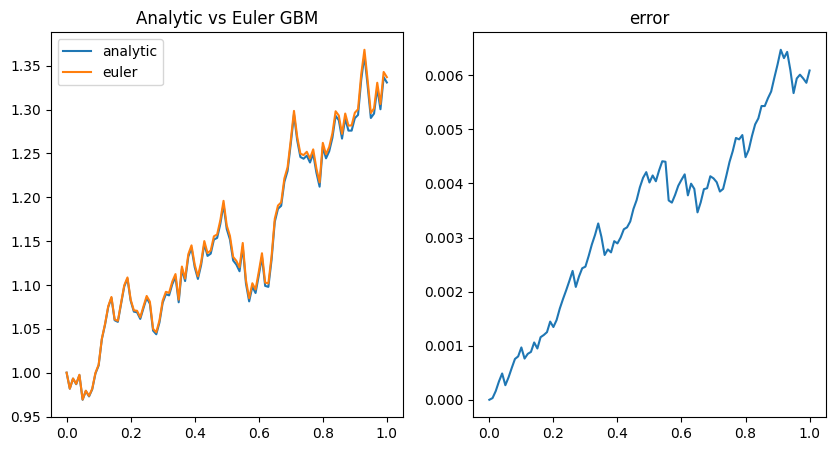

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_GBM_path(S0, mu, sigma, T, dt, num_paths):
    """Simulate multiple paths of the geometric Brownian motion process S_{t}=S_{0} exp((r-sigma^2/2)t + sigma*W_{t})"""
    N = round(T/dt)
    t = np.linspace(0, T, N+1)
    W = np.random.standard_normal(size = (num_paths, N)) 
    W = np.insert(W, 0, 0, axis=1)
    W = np.cumsum(W, axis=1)*np.sqrt(dt) ### standard brownian motion
    X = (mu - 0.5*sigma**2)*t + sigma*W 
    S = S0*np.exp(X) ### geometric brownian motion
    return S

def euler_maruyama(X0, mu, sigma, T, N, num_paths):
    dt = T/N
    t = np.linspace(0, T, N+1)
    X = np.zeros((num_paths, N+1))
    X[:, 0] = X0
    for j in range(num_paths):
        for i in range(1, N+1):
            X[j, i] = X[j, i-1] + mu(t[i-1], X[j, i-1]) * dt + sigma(t[i-1],X[j, i-1]) * np.random.normal(0,np.sqrt(dt))
    return t, X

def muGBM(mu): return lambda t, X: mu*X
def sigmaGBM(sigma): return lambda t,X: sigma*X

mu = 0.07
sigma = 0.2
X0 = 1
T = 1 
N = 100
seed = np.random.randint(0,100000)
np.random.seed(seed)
realization_euler_gbm = euler_maruyama(X0, muGBM(mu), sigmaGBM(sigma), T, N,1)

np.random.seed(seed)
paths = simulate_GBM_path(X0, mu, sigma, T, T/N, 1)

fig, axs = plt.subplots(1,2,figsize=(10,5))

# First subplot
axs[0].plot(np.linspace(0,T,N+1), paths[0, :], label="analytic")
axs[0].plot(realization_euler_gbm[0], realization_euler_gbm[1][0,:], label="euler")
axs[0].legend()
axs[0].set_title('Analytic vs Euler GBM')

# Second subplot
axs[1].plot(realization_euler_gbm[0], realization_euler_gbm[1][0,:]-paths[0,:], label="euler")
axs[1].set_title('error')

plt.show()

## Euler scheme backward part
See course slides:

$$
\left\{\begin{array} {l} {{{Y_{t_{N}}^{N}=\Phi\left( X_{t_{N}}^{N} \right),}}} \\ {{{Z_{t_{i}}^{N}=\frac{1} {\Delta_{i}^{N}} \mathbb{E} \left[ \Delta W_{i}^{N} Y_{t_{i+1}}^{N} \mid\mathcal{F}_{t_{i}} \right],}}} \\ {{{Y_{t_{i}}^{N}=\mathbb{E} \left[ Y_{t_{i+1}}^{N}+\Delta_{i}^{N} f \left( t_{i}, X_{t_{i}}^{N}, Y_{t_{i+1}}^{N}, Z_{t_{i}}^{N} \right) \mid\mathcal{F}_{t_{i}} \right].}}} \\ \end{array} \right. 
$$


## Comparing to PDE equivalence
To start (or simplicity) we consider 1-dimensional case and
 simpler $f$ linear in $u$, the relation between FBSDE and PDE is then the linear Feynman-Kac formula:

$$
f(r,x,y,z)= l(t,x) + \gamma u .
$$ 

$$
u_{t} + \frac{1}{2} \sigma^{2} u_{xx} + \mu u_{x} + \gamma u + l(t,x) = 0.
$$ 
then 
$$
(X_{t},Y_{t} = u(t,X_{t}), Z_{t} = \sigma(t,X_{t}) u_{x}(t,X_{t}))
.
$$ 
is solution. We use as test example:
$$
\begin{align}
u(t,x) &= tx \\    
\mu(t,x) &= -x \\
\sigma(t,x)&= t \\ 
\gamma &= 1  \\
l(t,x) &= -x
\end{align}
$$ 



We plot some realizations of the forward process:

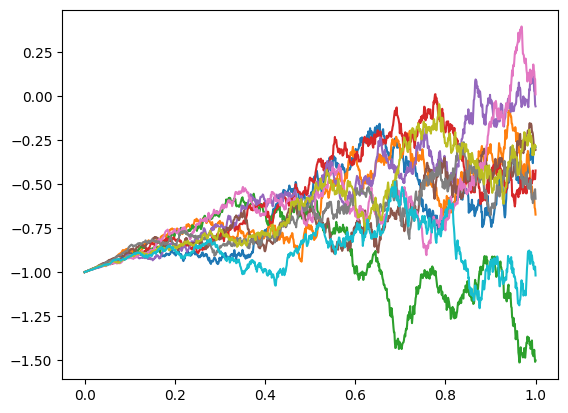

In [49]:
np.random.seed(1000)
realization_euler_gbm = euler_maruyama(-1, lambda t,x:-x, lambda t,x:t, 1, 1000,10)
for p in realization_euler_gbm[1]:
    plt.plot(realization_euler_gbm[0], p)
plt.show()

## Least-squares regression based method
See course notes.

In [ ]:
from sklearn.linear_model import LinearRegression

def least_square_bsde(paths,f,phi):
    Y = phi(paths[1][:,-1])
    for t,col in zip(paths[0][-2::-1],paths[1][:1:-1]):
        X = np.column_stack([col,col^2])
        model = linear_model.LinearRegression()
        reg = LinearRegression().fit(X,Y)
        Y = reg.predict(X)
        Y = np.maximum(Y,phi(col))



